# Detection des SPAMS

## Import des bibliothèques


In [3]:
#!python -m pip install wordcloud



In [6]:
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style("darkgrid")

import string
import nltk
from nltk.corpus import stopwords

from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn import metrics


## Import de la base 

In [10]:
messages = pd.read_csv("spam.csv", encoding="latin-1")
messages.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


## Analyse et traitement de données 

In [11]:
messages.tail()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN
5571,ham,Rofl. Its true to its name,NaN,NaN,NaN


**Supprimer les colonnes inutiles**

In [12]:
messages = messages.drop(labels= ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)
messages.columns = ["label" , "message"]


**Informations**

In [13]:
messages.head()


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [14]:
messages.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [15]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [16]:
messages.groupby('label').describe().T

label                              ham  \
message count                     4825   
        unique                    4516   
        top     Sorry, I'll call later   
        freq                        30   

label                                                        spam  
message count                                                 747  
        unique                                                653  
        top     Please call our customer service representativ...  
        freq                                                    4

**Afin d'analyser le dataset spam, on va créer une fonctionnalité pour détecter la longueur des messages textuels.**

In [17]:
messages['length'] = messages['message'].apply(len)
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


**Compter la frequence des messages qui se repetent sur le dataset**

In [18]:
messages['message'].value_counts().rename_axis(['message']).reset_index(name='counts').head()

,message,counts
0,"Sorry, I'll call later",30
1,I cant pick the phone right now. Pls send a me...,12
2,Ok...,10
3,7 wonders in My WORLD 7th You 6th Ur style 5th...,4
4,"Say this slowly.? GOD,I LOVE YOU &amp; I NEED ...",4


**Visualiser le dataset**

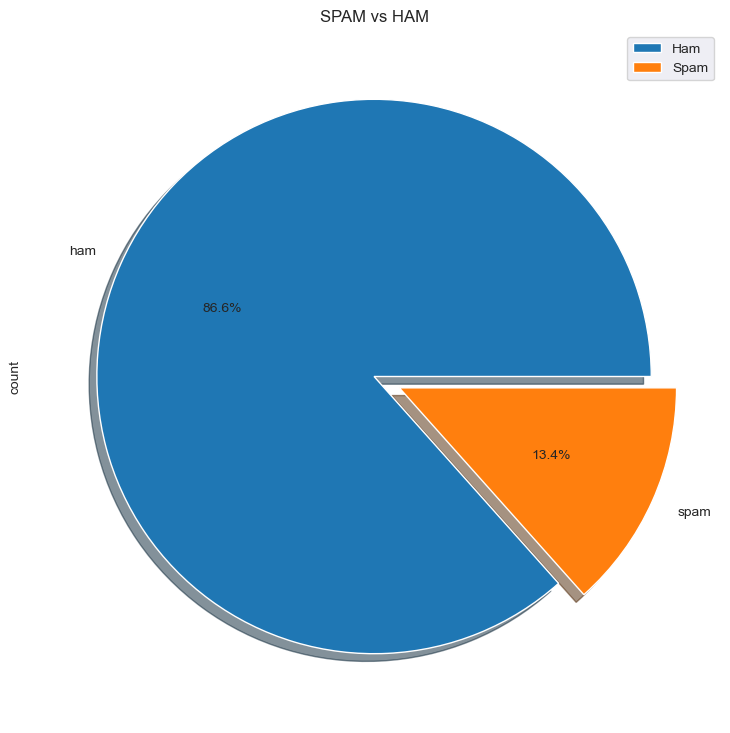

In [24]:
messages['label'].value_counts().plot(kind='pie',explode=[0,0.1],figsize=(9,9),autopct='%1.1f%%',shadow=True)
plt.title("SPAM vs HAM")
plt.legend(["Ham","Spam"])
plt.show()

Text(0, 0.5, 'fréquence')

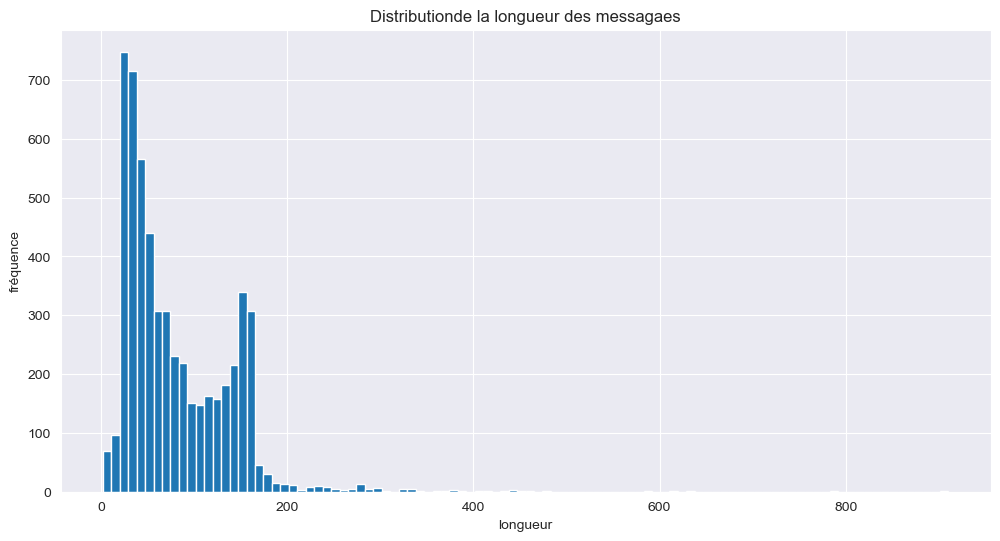

In [26]:
plt.figure(figsize=(12,6))
messages['length'].plot(bins=100,kind='hist')
plt.title('Distributionde la longueur des messagaes')
plt.xlabel("longueur")
plt.ylabel("fréquence")

array([<Axes: title={'center': 'ham'}>, <Axes: title={'center': 'spam'}>],
      dtype=object)

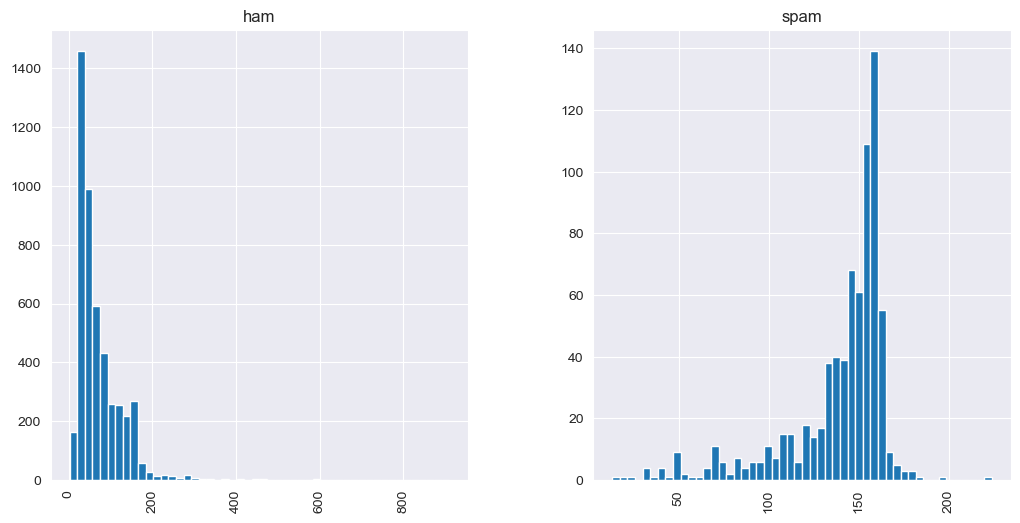

In [25]:
messages.hist(column='length', by='label', bins=50,figsize=(12,6))

In [27]:
messages[messages['length']==910]["messages"].iloc[0]

KeyError: 'messages'

Text(0.5, 0, 'Message Length')

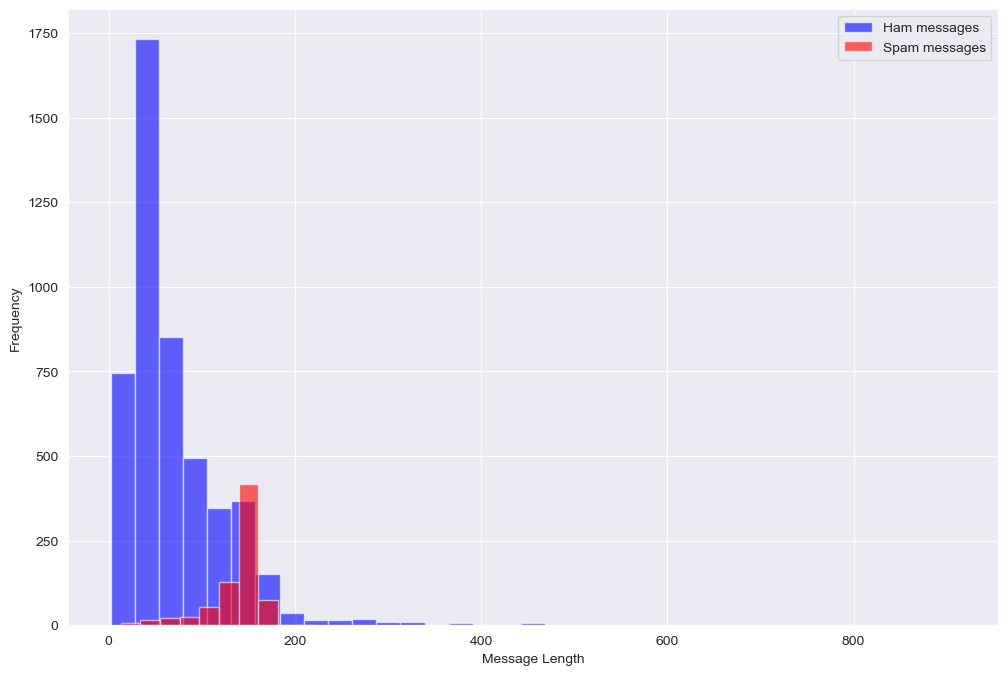

In [28]:
#representation de la longeur des messages par label
plt.figure(figsize=(12, 8))

messages[messages.label == 'ham'].length.plot(bins=35, kind='hist', color='blue',
                                        label='Ham messages', alpha=0.6)
messages[messages.label == 'spam'].length.plot(kind='hist', color='red',
                                        label='Spam messages', alpha=0.6)
plt.legend()
plt.xlabel("Message Length")

In [29]:
def text_preprocess(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    nopunc = nopunc.lower()
    
    # Now just remove any stopwords and non alphabets
    nostop = [word for word in nopunc.split() if word.lower() not in stopwords.words('english') and word.isalpha()]
    return nostop

In [34]:
spam_messages = messages[messages["label"] == "spam"]["message"]
ham_messages = messages[messages["label"] == "ham"]["message"]
nltk.download('stopwords')
spam_words = text_preprocess(spam_messages)
ham_words = text_preprocess(ham_messages)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rymkm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


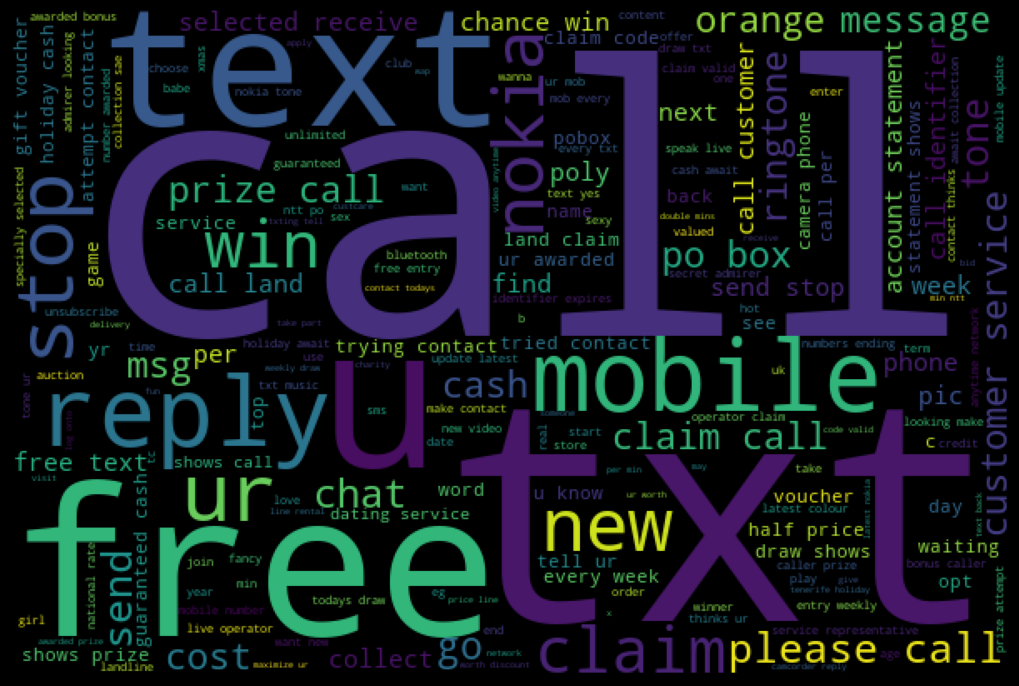

In [32]:
spam_wordcloud = WordCloud(width=600, height=400).generate(' '.join(spam_words))
plt.figure( figsize=(10,8), facecolor = 'k')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

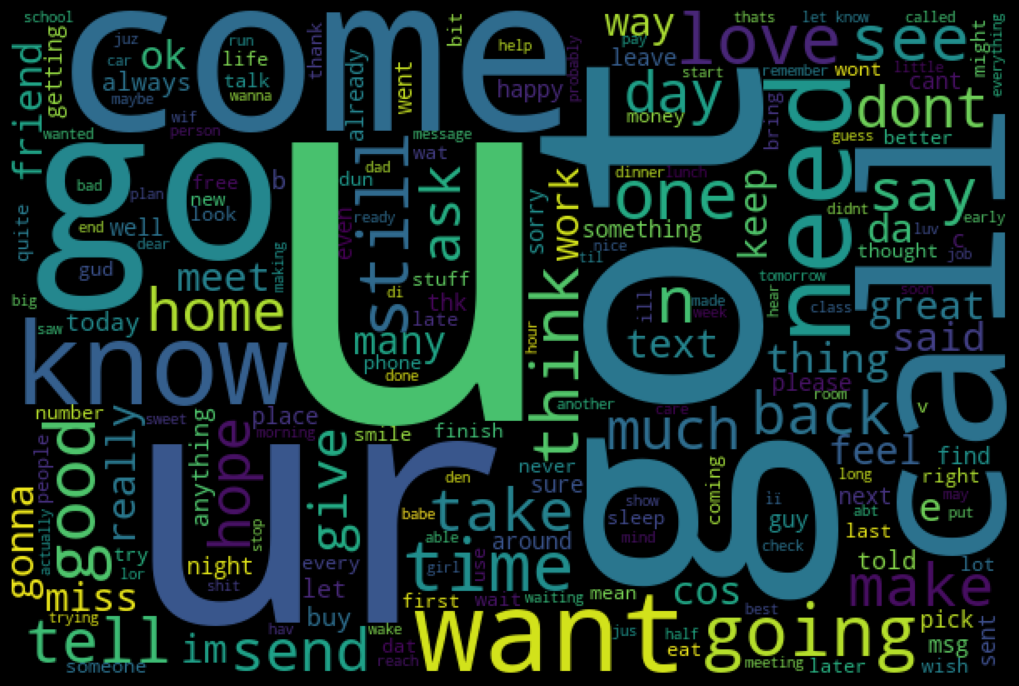

In [35]:
ham_wordcloud = WordCloud(width=600, height=400).generate(' '.join(ham_words))
plt.figure( figsize=(10,8), facecolor = 'k')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()